## Librerías, modulos y configuración de la notebook 

In [1]:
#### Librerías y modulos ####
import pandas as pd
import numpy as np
import seaborn as sns
import os,json
import matplotlib.pyplot as plt
import sklearn
from pandas.io import gbq
from datetime import datetime
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

In [2]:
#### Configuraciones de la notebook ####
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [3]:
#### Parametros de la notebook ####
path_save = '../datos/'

## Load data

In [5]:
# Upload del pickle generado en la notebook "make_data"
df = pd.read_pickle('{}df_meli_2022-02-14.pkl'.format(path_save))

In [6]:
df.shape

(3907159, 42)

## Preprocessing 

**Eliminar duplicados**

In [6]:
# Tratamiento de la feautre "runtime"
df['runtime'] = pd.to_datetime(df.runtime.apply(lambda x: str(x)[:19]))
df = df.sort_values(['runtime'])
# Ahora si, teniendo el df ordenado, eliminamos los duplicados, quedandonos con el registro más reciente (la última ocurrencia)
df.drop_duplicates(subset=['car_id'], keep='last', inplace=True)

In [7]:
df.shape

(166981, 42)

**Dropeamos los precios en dolares**

Representan un 14% de la base !!! Caía mucho el test sin estos casos

In [8]:
# # observamos su volumen
# mask = df.price_symbol == 'U$S'
# display(df[mask].shape)
# display(round(df[mask].shape[0]/len(df),2))
# # dropeamos
# df.drop(list(df[mask].index),axis=0,inplace=True)
# display(df.shape)

In [9]:
# Construcción del precio final
blue= 215
oficial= 112.97
col1 = 'price_symbol'
col2 = 'car_kms'
conditions = [df[col1]!='U$S', (df[col1]=='U$S') & (df[col2]==0), (df[col1]=='U$S') & (df[col2]!=0)]
choices = [df.price_amount, df['price_amount']*oficial, df['price_amount']*blue]

df['price_meli_ok'] = np.select(conditions, choices, default=np.nan)

**Dropeamos 0kms y concesionaria**

In [10]:
df['dealer'] = np.where(df['dealer']==True,1,0)
mask_not_0km = df.car_kms > 90
mask_not_conces = df.dealer == 0

df = df[(mask_not_0km) & (mask_not_conces)]

In [11]:
df.shape

(69241, 43)

**Dropeamos match_score por debajo de 50%**

In [12]:
lst = ['score_marca_a','score_modelo_a','score_v1_c']
for col in lst:
    df = df[df[col]>=50]
    
# chequeo
df[lst].min()

score_marca_a    90.00
score_modelo_a   50.00
score_v1_c       50.00
dtype: float64

In [13]:
df.shape

(64460, 43)

**Dropeamos categorías que no nos sirven**

In [14]:
cats_loc1_ok = ['Capital Federal','Bs.As. G.B.A. Sur','Bs.As. G.B.A. Norte'
           ,'Bs.As. G.B.A. Oeste','Buenos Aires Interior','Bs.As. Costa Atlántica']
mask1 = df.car_location_1.apply(lambda x: x in cats_loc1_ok)
cats_brand_ok =['Alfa Romeo','Audi','BMW','Chery','Chevrolet','Citroën','DS','Fiat','Ford','Geely','Haval','Honda',
 'Hyundai','JAC','Jeep','Kia','Land Rover','Lifan','Mercedes-Benz','Mini','Mitsubishi','Nissan','Peugeot','Porsche','RAM',
 'Renault','SEAT','Shineray','Smart','Subaru','Suzuki','Toyota','Volkswagen','Volvo'] # Exclusion x pedido Edgar: Dodge, Chrysler
mask2 = df.brand.apply(lambda x: x in cats_brand_ok)
sub_mask = df.brand == 'Jeep'
lst_not_renegade = [i for i in df[sub_mask]['match_modelo_a'].unique() if i != 'Renegade']
mask3 = df.match_modelo_a.apply(lambda x: x not in lst_not_renegade)
df = df[(mask1 & mask2 & mask3)]

In [15]:
df.shape

(45444, 43)

**Dropeamos registros que no sean de los ultimos 15 días**

In [16]:
df.runtime.max()

Timestamp('2022-02-13 23:01:26')

In [17]:
from datetime import date, datetime, timedelta
# df.runtime.max() - timedelta(days=15) 

In [18]:
max_date = df.runtime.max()
mask_last15d = (df.runtime <= max_date) & ((df.runtime >= max_date - timedelta(days=15)))
df = df[mask_last15d]

In [19]:
print(df.runtime.min())
print(df.runtime.max())

2022-01-30 00:00:20
2022-02-13 23:01:26


In [20]:
df.shape

(29677, 43)

**Salvamos el dataset con las excluciones**

In [21]:
df.to_csv('{}dataset_final_2022-02-14.pkl'.format(path_save))

**Dropeamos outliers**

In [22]:
dic_outl_thres = {}
dic_outl_thres['q_99_p'] = np.quantile(df['price_meli_ok'],.99)
dic_outl_thres['q_005_p'] = np.quantile(df['price_meli_ok'],0.005)
dic_outl_thres['q_99_km'] = np.quantile(df['car_kms'],.99)
dic_outl_thres['q_005_km'] = np.quantile(df['car_kms'],0.005)

for col in dic_outl_thres:
    print('{} threshold to drop outliers: {}'.format(col, dic_outl_thres[col]))

q_99_p threshold to drop outliers: 11394836.6
q_005_p threshold to drop outliers: 540000.0
q_99_km threshold to drop outliers: 310000.0
q_005_km threshold to drop outliers: 1000.0


In [23]:
# Guardamos el diccionario en formato json
with open('{}thres_outl.txt'.format(path_save), 'w') as outfile:
    json.dump(dic_outl_thres, outfile)

In [24]:
# # Aplicamos tanto en train como en test
df = df[(df.price_meli_ok <= dic_outl_thres['q_99_p']) & (df.car_kms <= dic_outl_thres['q_99_km'])]
print(df.shape)

(29094, 43)


In [25]:
# chequeamos distribucion del target
df.price_meli_ok.describe(percentiles=[0.001,0.01,0.1,0.25,0.5,0.75,0.9,0.99])

count      29094.00
mean     2417189.27
std      1741298.47
min        50000.00
0.1%      450000.00
1%        600000.00
10%       890000.00
25%      1250000.00
50%      1890000.00
75%      3000000.00
90%      4690000.00
99%      9137500.00
max     11394785.00
Name: price_meli_ok, dtype: float64

<AxesSubplot:xlabel='price_meli_ok', ylabel='Density'>

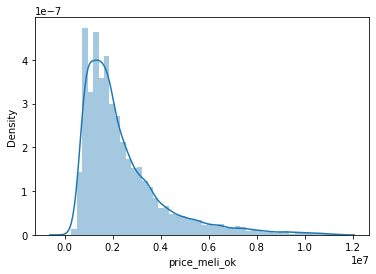

In [28]:
# chequeamos distribucion del target
sns.distplot(df.price_meli_ok)

**Dropeamos nulos**

No hay presencial de nulos para imputar o dropear

## Split

In [32]:
model_features = ['car_year','car_kms','match_marca_a','match_modelo_a','match_v1_c', 'Subseg_a', 'Seg_a']
target = ['price_meli_ok']
id_features = ['runtime','car_id']

In [33]:
df.price_meli_ok.describe()

count      29094.00
mean     2417189.27
std      1741298.47
min        50000.00
25%      1250000.00
50%      1890000.00
75%      3000000.00
max     11394785.00
Name: price_meli_ok, dtype: float64

In [36]:
X = df[model_features]
y = df.price_meli_ok

# 200 bines para discretizar la variable continua
bins = np.linspace(0, len(y), 200)
# Save your Y values in a new ndarray,
# broken down by the bins created above.
y_binned = np.digitize(y, bins)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20,  stratify=y_binned,random_state=42)
print(X_train.shape, X_test.shape)

(23275, 7) (5819, 7)


In [37]:
# chequeamos distribuciones del target en ambos dfs
a = pd.concat([y_train.describe(percentiles=[0.001,0.01,0.1,0.25,0.5,0.75,0.9,0.99])
              ,y_test.describe(percentiles=[0.001,0.01,0.1,0.25,0.5,0.75,0.9,0.99])],axis=1)
a.columns = ['price_train','price_test']
a

,price_train,price_test
count,23275.00,5819.00
mean,2416093.85,2421570.79
std,1740873.62,1743139.62
min,50000.00,300000.00
0.1%,450000.00,450000.00
1%,600000.00,600000.00
10%,890000.00,880000.00
25%,1250000.00,1250000.00
50%,1880000.00,1890000.00
75%,3000000.00,2985000.00


<AxesSubplot:xlabel='price_meli_ok', ylabel='Density'>

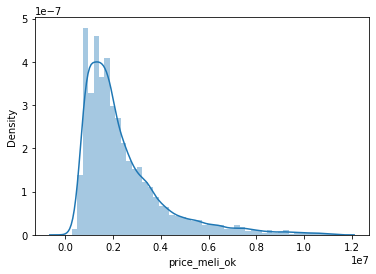

In [38]:
sns.distplot(y_train)

<AxesSubplot:xlabel='price_meli_ok', ylabel='Density'>

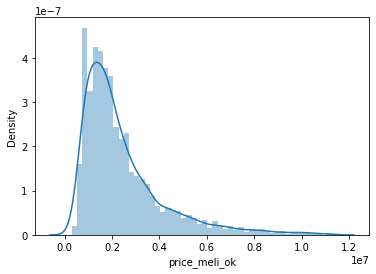

In [39]:
sns.distplot(y_test)

In [40]:
# chequeamos distribuciones del target en ambos dfs
a = pd.concat([X_train.car_kms.describe(percentiles=[0.005,0.01,0.1,0.25,0.5,0.75,0.9,0.99])
              ,X_test.car_kms.describe(percentiles=[0.005, 0.01,0.1,0.25,0.5,0.75,0.9,0.99])],axis=1)
a.columns = ['kms_train','kms_test']
a

,kms_train,kms_test
count,23275.00,5819.00
mean,105263.13,105110.45
std,60624.46,60801.63
min,108.00,95.00
0.5%,1000.00,1000.00
1%,1153.70,1518.00
10%,29000.00,28000.00
25%,60000.00,60000.00
50%,100000.00,99954.00
75%,143000.00,143369.50


## Modelo Baseline

In [49]:
model=CatBoostRegressor(loss_function='RMSE',logging_level="Silent")
categorical_features_indices = np.where(X_train[model_features].dtypes != np.float)[0]
model.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))

test_preds = model.predict(X_test)
train_preds = model.predict(X_train)

from catboost.utils import eval_metric

print("Train R2 : %.3f"%model.score(X_train, y_train))
print("\nTest  R2 : %.3f"%model.score(X_test, y_test))

Train R2 : 0.919

Test  R2 : 0.908


## Optimización de Hiperparametros

In [52]:
# A)
parameters = {'depth'         : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1, 0.15],
              'iterations'    : [100, 120, 150, 200, 250],
              'l2_leaf_reg': [0.2, 0.5, 1, 3]
             }


#model.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))

model=CatBoostRegressor(loss_function='RMSE',logging_level="Silent")
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 5, n_jobs= -1, scoring='r2')
categorical_features_indices = np.where(X_train[model_features].dtypes != np.float)[0]
grid.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))    

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n",
      grid.best_estimator_)

print("\n The best score across ALL searched params:\n",
      grid.best_score_)

print("\n The best parameters across ALL searched params:\n",
      grid.best_params_)

print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.903949360152815

 The best parameters across ALL searched params:
 {'depth': 10, 'iterations': 250, 'l2_leaf_reg': 0.5, 'learning_rate': 0.1}



In [57]:
# B)
parameters = {'depth'         : [6,8,10,12],
              'learning_rate' : [0.01, 0.05, 0.1, 0.15],
              'iterations'    : [100, 120, 150, 200, 250, 300],
              'l2_leaf_reg': [0.2, 0.5, 1, 3]
             }


#model.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))

model=CatBoostRegressor(loss_function='RMSE',logging_level="Silent")
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 5, n_jobs= -1, scoring='r2')
categorical_features_indices = np.where(X_train[model_features].dtypes != np.float)[0]
grid.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))    

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n",
      grid.best_estimator_)

print("\n The best score across ALL searched params:\n",
      grid.best_score_)

print("\n The best parameters across ALL searched params:\n",
      grid.best_params_)

print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.9045289461961161

 The best parameters across ALL searched params:
 {'depth': 10, 'iterations': 300, 'l2_leaf_reg': 0.5, 'learning_rate': 0.1}



In [59]:
# C)
parameters = {'depth'         : [6,8,10,12],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [100, 120, 150, 200, 250, 300, 350, 400],
              'l2_leaf_reg': [0.2, 0.5, 1, 3]
             }


#model.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))

model=CatBoostRegressor(loss_function='RMSE',logging_level="Silent")
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 5, n_jobs= -1, scoring='r2')
categorical_features_indices = np.where(X_train[model_features].dtypes != np.float)[0]
grid.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))    

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n",
      grid.best_estimator_)

print("\n The best score across ALL searched params:\n",
      grid.best_score_)

print("\n The best parameters across ALL searched params:\n",
      grid.best_params_)

print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.9050251699254165

 The best parameters across ALL searched params:
 {'depth': 10, 'iterations': 400, 'l2_leaf_reg': 1, 'learning_rate': 0.1}



## Final models

In [54]:
# A)
model=CatBoostRegressor(iterations=250, depth=10, learning_rate=0.1, l2_leaf_reg= 0.5,loss_function='RMSE',logging_level="Silent")
categorical_features_indices = np.where(X_train[model_features].dtypes != np.float)[0]
model.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))

test_preds = model.predict(X_test)
train_preds = model.predict(X_train)

from catboost.utils import eval_metric

print("Train R2 : %.3f"%model.score(X_train, y_train))
print("\nTest  R2 : %.3f"%model.score(X_test, y_test))

Train R2 : 0.928

Test  R2 : 0.913


In [58]:
# B)
model=CatBoostRegressor(iterations=300, depth=10, learning_rate=0.1, l2_leaf_reg= 0.5,loss_function='RMSE',logging_level="Silent")
categorical_features_indices = np.where(X_train[model_features].dtypes != np.float)[0]
model.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))

test_preds = model.predict(X_test)
train_preds = model.predict(X_train)

from catboost.utils import eval_metric

print("Train R2 : %.3f"%model.score(X_train, y_train))
print("\nTest  R2 : %.3f"%model.score(X_test, y_test))

Train R2 : 0.930

Test  R2 : 0.915


In [60]:
# C)
model=CatBoostRegressor(iterations=400, depth=10, learning_rate=0.1, l2_leaf_reg= 1,loss_function='RMSE',logging_level="Silent")
categorical_features_indices = np.where(X_train[model_features].dtypes != np.float)[0]
model.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))

test_preds = model.predict(X_test)
train_preds = model.predict(X_train)

from catboost.utils import eval_metric

print("Train R2 : %.3f"%model.score(X_train, y_train))
print("\nTest  R2 : %.3f"%model.score(X_test, y_test))

Train R2 : 0.934

Test  R2 : 0.914


## Best MODEL

*El mejor modelo es con el set de hiperparametros B) !* <br>
* iterations=300
* depth=10
* learning_rate=0.1
* l2_leaf_reg= 0.5
* loss_function='RMSE'

In [62]:
model=CatBoostRegressor(iterations=300, depth=10, learning_rate=0.1, l2_leaf_reg= 0.5,loss_function='RMSE',logging_level="Silent")
categorical_features_indices = np.where(X_train[model_features].dtypes != np.float)[0]
model.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))

test_preds = model.predict(X_test)
train_preds = model.predict(X_train)

from catboost.utils import eval_metric

print("Train R2 : %.3f"%model.score(X_train, y_train))
print("\nTest  R2 : %.3f"%model.score(X_test, y_test))

Train R2 : 0.930

Test  R2 : 0.915


In [64]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,car_year,22.50
1,Subseg_a,18.43
2,match_marca_a,17.62
3,match_modelo_a,13.42
4,car_kms,11.65
5,Seg_a,9.98
6,match_v1_c,6.39


In [65]:
!pwd

/Users/santiago.lean/repos/kardur_cotizador/notebooks_train


In [66]:
# Save del modelo fiteado

path_model_save = '../model/'

import pickle
with open('{}model_catboost_v2.pickle'.format(path_model_save), 'wb') as f:
    pickle.dump(model, f)

## Validacion OOT

In [55]:
# pending

Mejoras:

* Feature flag de los casos raros como 111111 o 9999999 para sumarla como predictora. Si bien ya removimos muchos mediante el capeo de outliers,
    si estos casos son por ejemplo 111111 (es decir que no queda un valor extremo) tambien puede que sean absurdos pero no salten en la detecion de outliers
    Para esto lo mejor va a ser hacer un Feature flag de precios absurdos (no alcanzados por el capeo de outliers) estos casos no los vamos a dropear pero si a flaguear.
* Deteccion outliers más inteligente para kms --> tener en cuenta el año
    * Feature flag de outliers kms: esto en lugar que sea para dropear los registros se me ocurrió hacerlo a modo de flag que luego quede como variable predictora
* Sumar la feature de discontinuados (Favio)
* Los que tengan precios en dolares excluirlos y mandarselos a pricing (hacer un pequeño análisis del volumen de casos). No se pudo!
* Tuneo de Hiperparametros. LISTO!
* Features de InfoAutos (Cande se esta encargando de eso pero todavía no las tenemos)
* Mejor preprocesing a la feature version (ej: standarizar los valores para los casos de nula volatilidad en el precio)